In [45]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
# from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
# from mappings import *
from train_functions import *


#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)
train_data = rdkit2pyg(train_guac_mols[:32])


#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 

#! --- SET UP EXPERIMENT ---
LRrnn, LRout = 1e-5, 1e-5
wd = 5e-4
epoch, max_epoch = 1, 30
bs = 32 # 512

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=LRrnn)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


2.0.1


[18:28:13] WARNING: no name column found on line 0
[18:28:13] WARNING: no name column found on line 1
[18:28:13] WARNING: no name column found on line 2
[18:28:13] WARNING: no name column found on line 3
[18:28:13] WARNING: no name column found on line 4
[18:28:13] WARNING: no name column found on line 5
[18:28:13] WARNING: no name column found on line 6
[18:28:13] WARNING: no name column found on line 7
[18:28:13] WARNING: no name column found on line 8
[18:28:13] WARNING: no name column found on line 9
[18:28:13] WARNING: no name column found on line 10
[18:28:13] WARNING: no name column found on line 11
[18:28:13] WARNING: no name column found on line 12
[18:28:13] WARNING: no name column found on line 13
[18:28:13] WARNING: no name column found on line 14
[18:28:13] WARNING: no name column found on line 15
[18:28:13] WARNING: no name column found on line 16
[18:28:13] WARNING: no name column found on line 17
[18:28:13] WARNING: no name column found on line 18
[18:28:13] WARNING: no

In [48]:
# # # MEMORIZATION

# obs = train_guac_mols[5]
# print(Chem.MolToSmiles(obs))
# train_data = rdkit2pyg([obs])

# train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
# max_epoch = 2000
# params = list(rnn.parameters()) + list(output.parameters())
# optimizer = torch.optim.RMSprop(params, lr=LRrnn)
# # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

# def memorize_batch_single_opt(max_epoch, rnn, output, data_loader_, optimizer, node_weights, edge_weights, scheduler=None):
#     rnn.train()
#     output.train()    
#     epoch = 1
#     for _, data in enumerate(data_loader_): data = data
#     while epoch <= max_epoch:
#         rnn.zero_grad()
#         output.zero_grad()
#         loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         if epoch % 500 == 0: print(f'Epoch: {epoch}/{max_epoch}, lossEdges {edge_loss:.8f}, lossNodes {node_loss:.8f}')
#         epoch += 1

# memorize_batch_single_opt(max_epoch, rnn, output, train_dataset_loader, optimizer, node_weights, edge_weights, scheduler)
# Ns = [10]
# for i in Ns: generate_mols(i,rnn, output, epoch)

In [49]:
# LSUV

# # A hook executes a f that MUST takes 3 args: a module, an input and an output
# def _lsuv_stats(hook, module, inpt, outpt):
#     ''' For each layer stores mean/std'''
#     acts = to_cpu(outpt)
#     hook.mean = acts.mean()
#     hook.std = acts.std()

# def lsuv_init(activation_module, module_input_to_activation, xb):
#     '''
#     activation_module: module that contains the act func of the layer
#     module_input_to_activation: module that contain the weights used in activation_module
#     xb: batch    
#     '''    
#     h = Hook(activation_module, _lsuv_stats) # registers a forw_hook which executes _lsuv_stats
#     with torch.no_grad():
#         while(model(xb)) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
#             # modify weights untill activated layer has m=0, std=1
#             module_input_to_activation.bias -= h.mean
#             module_input_to_activation.weight.data /= h.std
#     h.remove()    

# Activations analysis

In [50]:
for idx, (name, module) in enumerate(rnn.named_children()):
    print(name)

embedding
rnn
output1
output2
node_mlp1
node_mlp2


In [51]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_output_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    else:
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []


def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    else:
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

In [52]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [53]:
epoch = 0
while epoch < max_epoch:
    loss, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                            data_loader_=train_dataset_loader,
                                            optimizer=optimizer,
                                            node_weights=node_weights, edge_weights=edge_weights,
                                            scheduler = scheduler)
    print(f"Epoch {epoch}, loss_edg: {loss_edg}, loss_nodes: {loss_nodes}")
    epoch +=1

# Epoch 29, loss_edg: 0.0012903999304398894, loss_nodes: 0.22438199818134308 with one cycle bs32
# Epoch 29, loss_edg: 0.26833605766296387, loss_nodes: 0.24406851828098297 with cos ann bs32
# Epoch 29, loss_edg: 0.0013933113077655435, loss_nodes: 0.21662618219852448 with one cycle bs 32




Epoch 0, loss_edg: 0.5547777414321899, loss_nodes: 0.289815753698349
Epoch 1, loss_edg: 0.5535827279090881, loss_nodes: 0.28952401876449585
Epoch 2, loss_edg: 0.549807071685791, loss_nodes: 0.28861016035079956
Epoch 3, loss_edg: 0.53846675157547, loss_nodes: 0.28592514991760254
Epoch 4, loss_edg: 0.514388918876648, loss_nodes: 0.2804658114910126
Epoch 5, loss_edg: 0.4736986458301544, loss_nodes: 0.27199527621269226
Epoch 6, loss_edg: 0.412738174200058, loss_nodes: 0.26123932003974915
Epoch 7, loss_edg: 0.3300987780094147, loss_nodes: 0.25097110867500305
Epoch 8, loss_edg: 0.23364287614822388, loss_nodes: 0.2444538027048111
Epoch 9, loss_edg: 0.14456364512443542, loss_nodes: 0.24178917706012726
Epoch 10, loss_edg: 0.08035635948181152, loss_nodes: 0.24029843509197235
Epoch 11, loss_edg: 0.04220929741859436, loss_nodes: 0.23797014355659485
Epoch 12, loss_edg: 0.02221967652440071, loss_nodes: 0.23471665382385254
Epoch 13, loss_edg: 0.012262716889381409, loss_nodes: 0.2316206395626068
Epoch

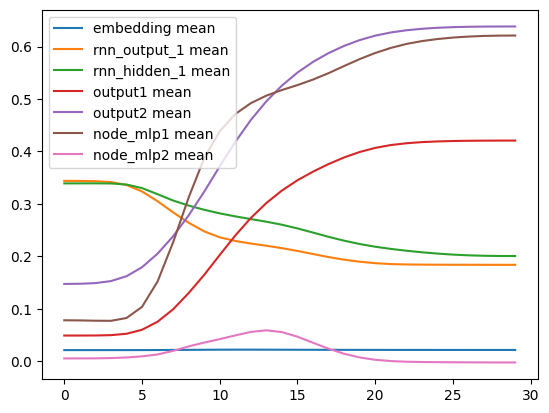

In [54]:
# figsize = 100
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

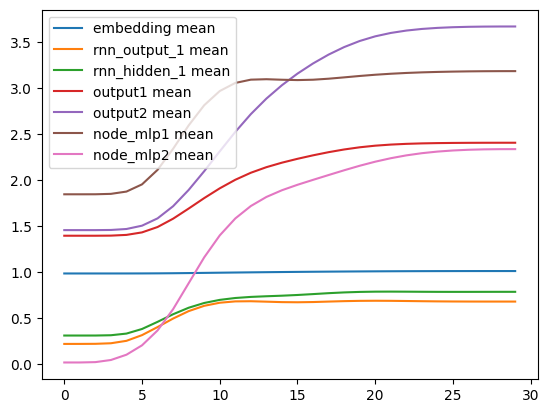

In [55]:
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

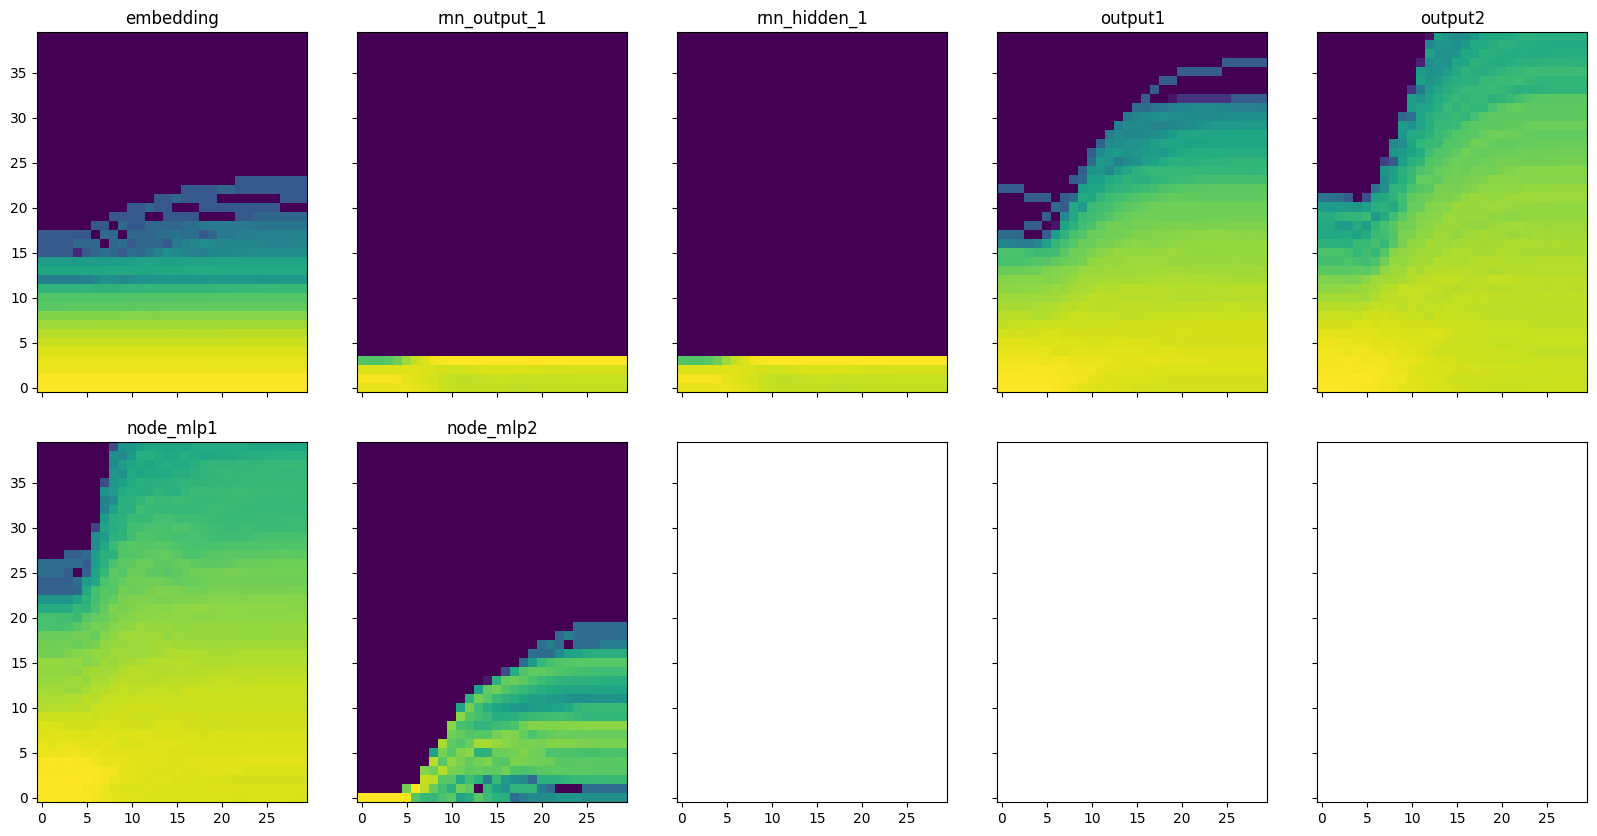

In [56]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): 
    return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_rnn.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_rnn[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

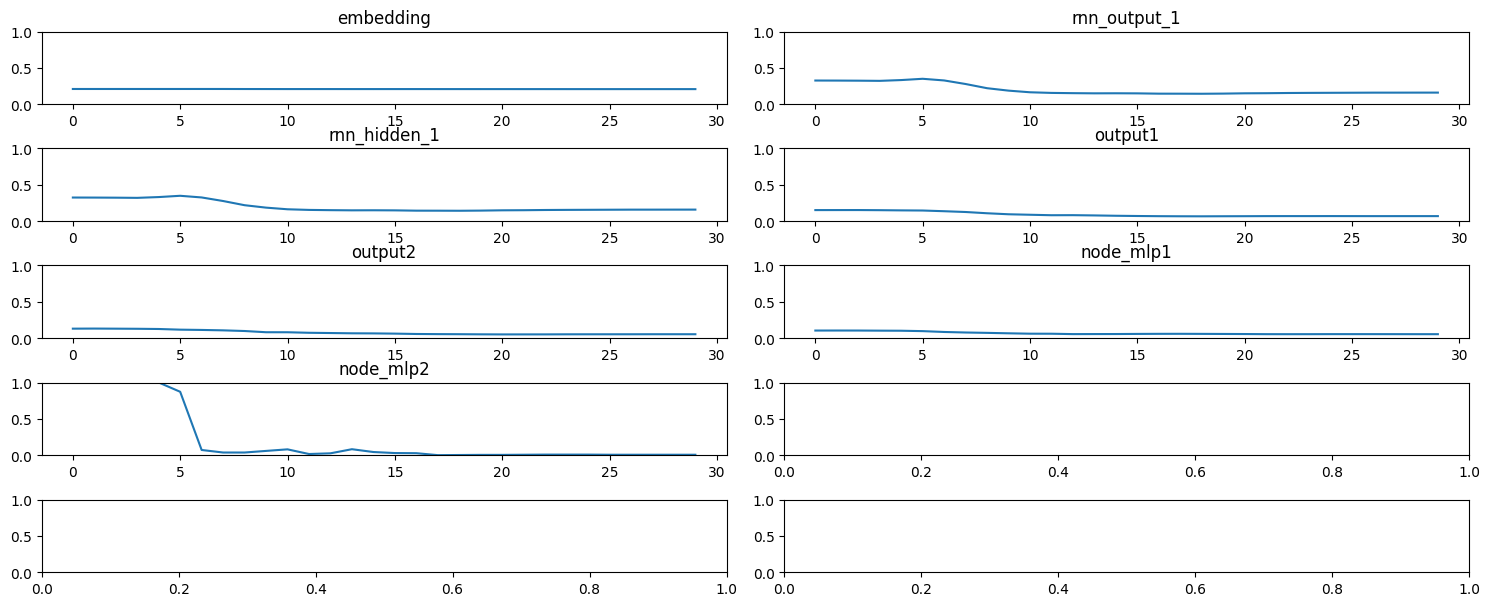

In [57]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(5,2, figsize=(15, 6))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_rnn.keys())):
    h = layer_hists_rnn[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)